## **Elaborazione di Immagini Mediche**
### 2021/22 - VESSELWALL SEGMENTATION CHALLENGE



# Enviroment settings

### Drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install library dependencies

In [ ]:
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install segmentation_models==1.0.1
!pip install h5py==2.10.0 
!pip install plotly==5.3.1
!pip install pydicom

### Import 

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import plotly.express as px

from datetime import datetime
from tqdm import tqdm

from matplotlib import pyplot as plt

from scipy import ndimage
from scipy.ndimage.interpolation import map_coordinates

import skimage
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio

import re

import keras
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical, normalize
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.metrics import MeanIoU

import segmentation_models as sm
from segmentation_models import Unet, Linknet
from segmentation_models import losses, metrics

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


### Dataset loading

In [ ]:
!unzip "/content/drive/MyDrive/Colab_Notebooks/EIM/Challenge/DATASET_Final_Left.zip"
!unzip "/content/drive/MyDrive/Colab_Notebooks/EIM/Challenge/DATASET_Final_Right.zip"

### Functions

In [ ]:
def sorted_alphanum(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

def elastic_transform(image, alpha_range, sigma, random_state=None): 
    if random_state is None: 
        random_state = np.random.RandomState(None)
    if np.isscalar(alpha_range): 
        alpha = alpha_range 
    else: 
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1]) 
    shape = image.shape 
    dx = ndimage.filters.gaussian_filter((random_state.rand(*shape)*2 - 1), sigma) * alpha 
    dy = ndimage.filters.gaussian_filter((random_state.rand(*shape)*2 - 1), sigma) * alpha 
    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij') 
    indices = np.reshape(x+dx, (-1,1)), np.reshape(y+dy, (-1,1)), np.reshape(z, (-1,1)) 
    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

# Dataset settings

In [ ]:
path = os.getcwd()
side = 'Left'         # cambiare con Right per allenare la rete per l'altro lato
dataset_name = f'DATASET_Final_{side}'
set_type = ('TRAIN','VALIDATION')

TRAIN_path = os.path.join(path, dataset_name, set_type[0])
VALID_path = os.path.join(path, dataset_name, set_type[1])


In [ ]:
# preparazione dataset per allenamento rete
IMG_WIDTH = int(720/2)  #left_right
IMG_HEIGHT = 100
IMG_CHANNELS = 3
NUM_CLASSES = 3

# ROI:
height = 100 
width = int(512/2)  #left_right

start = IMG_WIDTH-width

zeros_mat = np.zeros((14,width), dtype=np.uint8)

listOfPz_train = sorted_alphanum(os.listdir(TRAIN_path))
listOfPz_valid = sorted_alphanum(os.listdir(VALID_path))

### Preprocessing Evaluation

In [ ]:
# for pz in listOfPz_train[:1]:
#     vol = [imread(TRAIN_path+'/'+pz+'/'+img) for img in sorted(os.listdir(TRAIN_path+'/'+pz), key=len) if 'mask' not in img]
#     vol = np.array(vol)

#     rndm_idx = random.randint(0, len(sorted(os.listdir(TRAIN_path+'/'+pz))))
#     rndm_idx = 75
#     for image in sorted_alphanum(os.listdir(TRAIN_path+'/'+pz))[rndm_idx:rndm_idx+2]:
#         print(pz, image)
#         if 'mask' not in image:
#             img_raw = imread(TRAIN_path+'/'+pz+'/'+image)

#             N4 Bias Field Correction:
#             img_input = img_raw.astype(np.float32)
#             img_input = sitk.GetImageFromArray(img_input)
#             mask_input = sitk.OtsuThreshold(img_input,0,1)
#             img_corr = corrector.Execute(img_input,mask_input)
#             img_final = sitk.GetArrayFromImage(img_corr)
#             img_negative = img_final - img_input

#             img_final = img_final[:, 0:width]    # Left
#             img_final = img_final[:, start:]    # Right
#             img_final = img_final[:, start:width*2+start]    # Right
#             img_final = np.concatenate((zeros_mat,img_final,zeros_mat), axis=0)

#             img_equal = skimage.exposure.equalize_adapthist(img_final, nbins=256)
#             p2, p98 = np.percentile(img_final, (2, 98))  # constrast enhancement
#             img_intensity = skimage.exposure.rescale_intensity(img_final, in_range=(p2, p98))
#             img_norm = ((img_intensity-np.min(img_intensity)) / (np.max(img_intensity)-np.min(img_intensity))) * 1 # Normalisation: [0,1]
            
#             img_median = ndimage.filters.median_filter(img_norm, size=3, footprint=None)
#             img_bm3d = bm3d.bm3d(img_final, sigma_psd=0.15, stage_arg=bm3d.BM3DStages.ALL_STAGES)

#             edge_sobel = skimage.filters.sobel(img)
#             img_edge = img + edge_sobel

#             print(f"Random index: {rndm_idx}")
#             plt.figure(figsize=(60,30))
#             ax0 = plt.subplot(411)
#             ax0.imshow(img_raw, cmap='gray') ,ax0.set_title('Img raw')
#             ax1 = plt.subplot(412)
#             ax1.imshow(img_final, cmap='gray') ,ax1.set_title('Img final')
#             ax2 = plt.subplot(413)
#             ax2.imshow(img_norm, cmap='gray') ,ax2.set_title('Img Negative')
#             ax3 = plt.subplot(414)
#             ax3.imshow(img_median, cmap='gray') ,ax3.set_title('Img Median')
#             plt.show()

# Preprocessing

In [ ]:
# commentare/scommentare le righe relative al lato (dx o sx) su cui si vuole allenare
#------------------------- Training Set:
X_train_tmp = []
Y_train = []

print('Training:')
for pz in tqdm(listOfPz_train):
  print(f" Patient: {pz}")
  for image in sorted_alphanum(os.listdir(TRAIN_path+'/'+pz)):
    if 'mask' in image:
      mask = imread(TRAIN_path+'/'+pz+'/'+image, as_gray=True)
      mask = skimage.img_as_ubyte(mask)
      mask = mask[:, 0:width]   #left           #commentare e scommentare la riga sottostante a seconda del lato da allenare
      # mask = mask[:, start:]  #right

      mask = np.concatenate((zeros_mat,mask,zeros_mat), axis=0)
      Y_train.append(mask)

    else:
      img = imread(TRAIN_path+'/'+pz+'/'+image)
      img = skimage.img_as_ubyte(img)
      img = img[:, 0:width]    #Left
      # img = img[:, start:]    #Right

      p2, p98 = np.percentile(img, (2, 98))  
      img = skimage.exposure.rescale_intensity(img, in_range=(p2, p98))
           
      img = ndimage.filters.median_filter(img, size=2, footprint=None)
      img = np.concatenate((zeros_mat,img,zeros_mat), axis=0)

      X_train_tmp.append(img)

X_train_tmp = np.array(X_train_tmp)

z,x,y = X_train_tmp.shape
X_train_3D = np.zeros((z,x,y,IMG_CHANNELS), dtype=np.uint8)
X_train_3D[:,:,:,0] = X_train_tmp
X_train_3D[:,:,:,1] = X_train_tmp
X_train_3D[:,:,:,2] = X_train_tmp
X_train = X_train_3D

Y_train = np.array(Y_train)
Y_train = np.expand_dims(Y_train, axis=3)
Y_train = to_categorical(Y_train, num_classes=NUM_CLASSES, dtype=bool)

#------------------------- Validation Set:
X_val_tmp = []
Y_val = []

print('\nValidation:')
for pz in listOfPz_valid:
  print(f" Patient: {pz}")
  for image in tqdm(sorted_alphanum(os.listdir(VALID_path+'/'+pz))):
    if 'mask' in image:
      mask = imread(VALID_path+'/'+pz+'/'+image, as_gray=True)
      mask = skimage.img_as_ubyte(mask)
      mask = mask[:, 0:width]   #left
      # mask = mask[:, start:]  #right
      mask = np.concatenate((zeros_mat,mask,zeros_mat), axis=0)

      Y_val.append(mask)

    else:
      img = imread(VALID_path+'/'+pz+'/'+image, as_gray=True)
      img = skimage.img_as_ubyte(img)
      img = img[:, 0:width]    #Left
      # img = img[:, start:]    #Right

      p2, p98 = np.percentile(img, (2, 98))  
      img = skimage.exposure.rescale_intensity(img, in_range=(p2, p98))
           
      img = ndimage.filters.median_filter(img, size=2, footprint=None)
      img = np.concatenate((zeros_mat,img,zeros_mat), axis=0)

      X_val_tmp.append(img)

X_val_tmp = np.array(X_val_tmp)

z,x,y = X_val_tmp.shape
X_val_3D = np.zeros((z,x,y,IMG_CHANNELS), dtype=np.uint8)
X_val_3D[:,:,:,0] = X_val_tmp
X_val_3D[:,:,:,1] = X_val_tmp
X_val_3D[:,:,:,2] = X_val_tmp
X_val = X_val_3D

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=3)
Y_val = to_categorical(Y_val, num_classes=NUM_CLASSES, dtype=bool)

### Plot training and validation

Random Train: 779
Random Val: 96


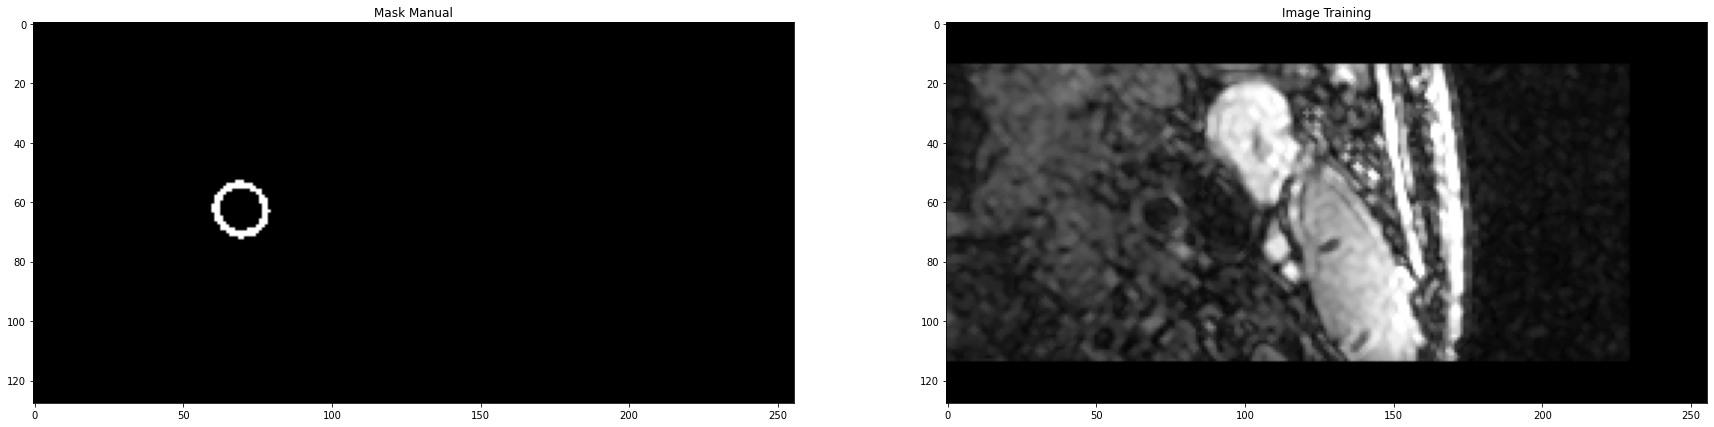

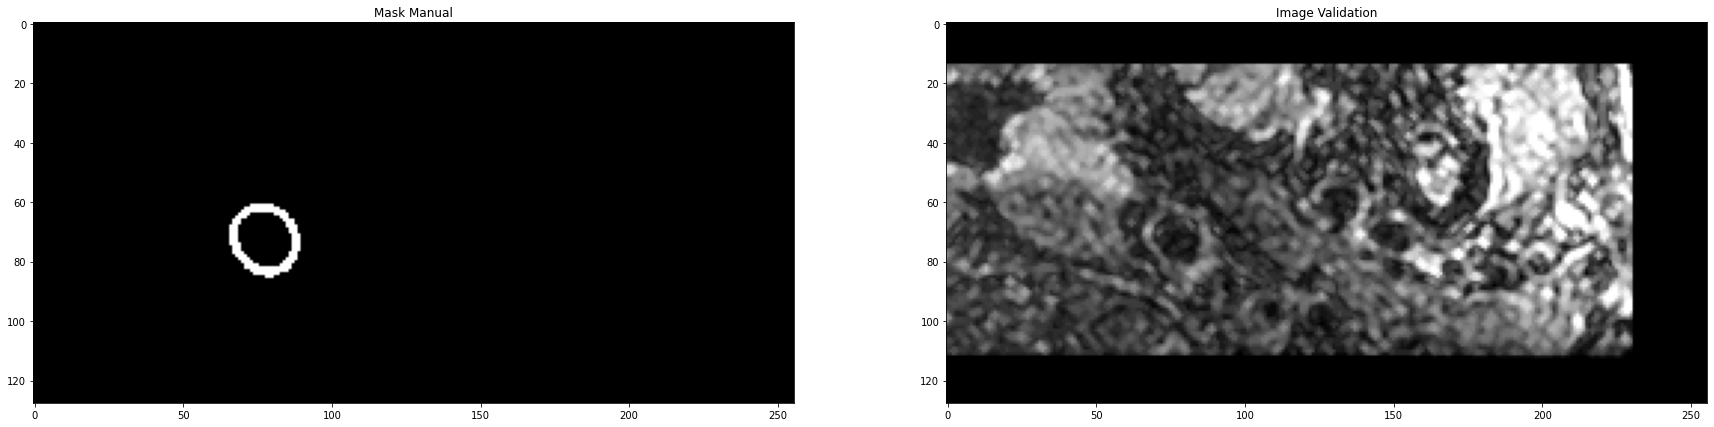

In [ ]:
set_label = 2

random_index_train = random.randint(0, len(X_train))
# random_index_train = 110

fig = plt.figure(figsize=(30,30))
ax2 = fig.add_subplot(121)
ax2.imshow(Y_train[random_index_train][:,:,set_label],cmap=plt.cm.gray), ax2.set_title('Mask Manual')
ax3 = fig.add_subplot(122)
ax3.imshow(X_train[random_index_train],cmap=plt.cm.gray), ax3.set_title('Image Training')

random_index = random.randint(0, len(X_val))
# random_index = 45

fig2 = plt.figure(figsize=(30,30))
ax2 = fig2.add_subplot(121)
ax2.imshow(Y_val[random_index][:,:,set_label],cmap=plt.cm.gray), ax2.set_title('Mask Manual')
ax3 = fig2.add_subplot(122)
ax3.imshow(X_val[random_index],cmap=plt.cm.gray), ax3.set_title('Image Validation')

print("Random index Train:",random_index_train)
print("Random index Val:",random_index)

# Data Augmentation

In [ ]:
image_datagen = ImageDataGenerator(rotation_range = 3, 
                                   width_shift_range = 0.08,
                                   height_shift_range = 0.08,
                                   zoom_range = 0.07,
                                   horizontal_flip = False,   
                                   vertical_flip = False,
                                   fill_mode = 'reflect', 
                                   preprocessing_function = lambda x: elastic_transform(x, alpha_range=[8,10], sigma=3)
                                   )

# Generator
batch_size = 16
seed = 1
def XYaugmentGenerator(X1, y, seed, batch_size): 
    genX1 = image_datagen.flow(X1, y, batch_size=batch_size, seed=seed) 
    genX2 = image_datagen.flow(y, X1, batch_size=batch_size, seed=seed) 
    while True: 
        X1i = genX1.next() 
        X2i = genX2.next() 
        yield X1i[0], X2i[0]

### Plot data augmentation

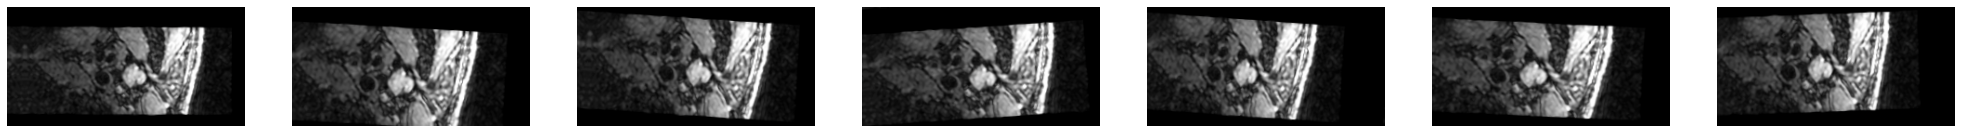

In [ ]:
random_index_train = random.randint(0, len(X_train))
img_tensor = X_train[random_index_train]
img_tensor = np.expand_dims(img_tensor, axis=0)

image_datagen.fit(img_tensor)
generator = image_datagen.flow(img_tensor, batch_size=1)

x = generator.next()[0].astype('uint8')

plt.figure(figsize=(40,20))
for i in range(1,8):
  plt.subplot(1,8,i)
  batch = generator.next()[0].astype('uint8')
  plt.axis('off')
  plt.imshow(batch)
plt.show()

# Model Definition

In [ ]:
# Optimizer:
initial_learning_rate = 0.001
opt = optimizers.Adam(lr=initial_learning_rate)

# Loss Function:
theta = 0.5
# label_weights = np.array([0.15, 0.5, 0.9])    # scommentare se si vogliono impostare dei pesi per label  

dice_loss = losses.DiceLoss()         #(class_weights = label_weights)
focal_loss = losses.CategoricalFocalLoss()
total_loss = dice_loss + (theta * focal_loss)

metric = [metrics.IOUScore(threshold=0.5), metrics.FScore(threshold=0.5)]

# Model:
ACTIVATION = 'softmax'
BACKBONE = 'resnet34'    
# BACKBONE = 'resnet152'
# BACKBONE = 'inceptionv3'   
# BACKBONE = 'inceptionresnetv2'
# BACKBONE = 'vgg16'  
# BACKBONE = 'vgg19'
# BACKBONE = 'densenet201'
# BACKBONE = 'efficientnetb7'

model = Unet(backbone_name = BACKBONE,
            encoder_weights = 'imagenet', 
            classes = NUM_CLASSES,
            activation = ACTIVATION,
            decoder_block_type = 'transpose',
            encoder_freeze = True,
            )
            
model.compile(optimizer=opt, loss=total_loss, metrics=metric)
# print(model.summary())

# Training

In [ ]:
# add = '_withall'   # scrivere tipo di preprocessing fatto
model_type = 'Unet'
path_mdl = '/content/drive/MyDrive/Colab_Notebooks/EIM/Challenge/Models'
name_mdl = f'model_{model_type}_{BACKBONE}_{side}.hdf5'

In [ ]:
# Parameters
batch_size = 16
n_epochs = 40

# Callbacks definition:
checkpointer = ModelCheckpoint(path_mdl+'/'+name_mdl, save_best_only=True)
schedule = ReduceLROnPlateau(monitor='val_loss', mode='auto', factor=0.1, patience=4, min_lr=initial_learning_rate/100)
earlystopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, min_delta=0.001, patience=8, restore_best_weights=True)
callbacks_list = [checkpointer, schedule, earlystopping]

# Data augmentation
start = datetime.now() 
history = model.fit_generator(XYaugmentGenerator(X_train, Y_train, seed, batch_size), 
                              validation_data = (X_val,Y_val), 
                              epochs = n_epochs,
                              steps_per_epoch = np.ceil(float(len(X_train))/float(batch_size)),   # len(X_train) // batch_size 
                              validation_steps = np.ceil(float(len(X_val))/float(batch_size)),
                              shuffle = True,
                              verbose = 1,
                              callbacks = callbacks_list
                              )
# No Data Augmentation
# history = model.fit(X_train,Y_train,        
#                     validation_data = (X_val,Y_val),
#                     epochs = n_epochs,
#                     batch_size = batch_size,
#                     verbose = 1,
#                     callbacks = callbacks_list,                    
#                     )

stop = datetime.now()

execution_time = stop-start
print("Unet execution time is: ", execution_time)

In [ ]:
#Salvataggio del modello allenato
n_epochs_actual = 22    #cambiare in base a quale epoca si è fermato (Early Stopping)

path_mdl = '/content/drive/MyDrive/Colab_Notebooks/EIM/Challenge/Models'
name_mdl = f'model_{model_type}_{BACKBONE}_{side}_nobestonly.hdf5'
model.save(path_mdl+'/'+name_mdl)

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
hist_filename = f'history_{model_type}_{BACKBONE}_{side}.csv'
with open(path_mdl+'/'+hist_filename, mode='w') as fp:
    hist_df.to_csv(fp)

## Load model

In [ ]:
# path_mdl = '/content/drive/MyDrive/Colab_Notebooks/EIM/Challenge/Models'
# name_mdl = 'unet_resnet34_20epochs_3classes_Left.hdf5'
# model = load_model(path_mdl+'/'+name_mdl, compile=False)

## Plot model's loss and metrics

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

iou = history.history['iou_score']
val_iou = history.history['val_iou_score']
f1 = history.history['f1-score']
val_f1 = history.history['val_f1-score']

epochs = range(1, len(loss) + 1)

name_fig = f'{model_type}_{BACKBONE}_{side}.png'

fig1 = plt.figure(figsize=(12,5))
ax1 = plt.subplot(111)
ax1.plot(epochs, loss, 'y', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss'), ax1.set_xlabel('Epochs'), ax1.set_ylabel('Loss'), ax1.legend()
plt.show()

fig2 = plt.figure(figsize=(25,7))
ax2 = plt.subplot(121)
ax2.plot(epochs, iou, 'y', label='Training IOU')
ax2.plot(epochs, val_iou, 'r', label='Validation IOU')
ax2.set_title('Training and Validation IOU'), ax2.set_xlabel('Epochs'), ax2.set_ylabel('IOU score'), ax2.legend()
ax2 = plt.subplot(122)
ax2.plot(epochs, f1, 'y', label='Training F1')
ax2.plot(epochs, val_f1, 'r', label='Validation F1')
ax2.set_title('Training and Validation F1'), ax2.set_xlabel('Epochs'), ax2.set_ylabel('F1 score'), ax2.legend()
plt.show()

fig1.savefig(path_mdl+'/'+'plot_loss'+name_fig)
fig2.savefig(path_mdl+'/'+'plot_metrics'+name_fig)

## Calculate prediction masks

In [ ]:
# Calcolo maschere automatiche per training
z,x,y,c = Y_train.shape
Mask_auto_train = np.zeros((z,x,y,c), dtype=np.uint8)
threshold = 0.5

cont_slice=0
print('Training:')
for slice_ in tqdm(X_train):
    img = np.expand_dims(slice_, axis=0)

    mask_auto = model.predict(img)
    mask_auto[mask_auto<threshold] = 0
    mask_auto[mask_auto>=threshold] = 1

    Mask_auto_train[cont_slice] = mask_auto
    cont_slice += 1

# Calcolo maschere automatiche per validation
z,x,y,c = Y_val.shape
Mask_auto_val = np.zeros((z,x,y,c), dtype=np.uint8)

cont_slice=0
print('Validation:')
for slice_ in tqdm(X_val):
  img = np.expand_dims(slice_, axis=0)

  mask_auto = model.predict(img)
  mask_auto[mask_auto<threshold] = 0
  mask_auto[mask_auto>=threshold] = 1

  Mask_auto_val[cont_slice] = mask_auto
  cont_slice += 1

Training:


100%|██████████| 1387/1387 [02:00<00:00, 11.48it/s]


Validation:


100%|██████████| 327/327 [00:26<00:00, 12.47it/s]


## Calculate overall DSC and RVD 

In [ ]:
#----------------Training
n_image = len(Mask_auto_train)

dice_lume_train = np.zeros(shape=(n_image))
dice_wall_train = np.zeros(shape=(n_image))
rvd_lume_train = np.zeros(shape=(n_image))
rvd_wall_train = np.zeros(shape=(n_image))

mask_manual_lume = Y_train[:,:,:,1]
mask_manual_wall = Y_train[:,:,:,2]

for i, slice_ in enumerate(Mask_auto_train):
    mask_auto_lume = slice_[:,:,1]
    intersection = np.sum(mask_auto_lume*mask_manual_lume[i])
    dice_lume_train[i] = (2*intersection) / (np.sum(mask_auto_lume) + np.sum(mask_manual_lume[i]))
    rvd_lume_train[i] = (np.sum(mask_auto_lume) - np.sum(mask_manual_lume[i])) / np.sum(mask_manual_lume[i])

    mask_auto_wall = slice_[:,:,2]
    intersection = np.sum(mask_auto_wall*mask_manual_wall[i])
    dice_wall_train[i] = (2*intersection) / (np.sum(mask_auto_wall) + np.sum(mask_manual_wall[i]))
    rvd_wall_train[i] = (np.sum(mask_auto_wall) - np.sum(mask_manual_wall[i])) / np.sum(mask_manual_wall[i])

#----------------Validation
n_image = len(Mask_auto_val)

dice_lume_val = np.zeros(shape=(n_image))
dice_wall_val = np.zeros(shape=(n_image))
rvd_lume_val = np.zeros(shape=(n_image))
rvd_wall_val = np.zeros(shape=(n_image))

mask_manual_lume = Y_val[:,:,:,1]
mask_manual_wall = Y_val[:,:,:,2]

for i, slice_ in enumerate(Mask_auto_val):
    mask_auto_lume = slice_[:,:,1]
    intersection = np.sum(mask_auto_lume*mask_manual_lume[i])
    dice_lume_val[i] = (2*intersection) / ( np.sum(mask_manual_lume[i]) + np.sum(mask_auto_lume) )  #Da commentare per il finale
    rvd_lume_val[i] = (np.sum(mask_auto_lume) - np.sum(mask_manual_lume[i])) / np.sum(mask_manual_lume[i])

    mask_auto_wall = slice_[:,:,2]
    intersection = np.sum(mask_auto_wall*mask_manual_wall[i])
    dice_wall_val[i] = (2*intersection) / (np.sum(mask_manual_wall[i]) + np.sum(mask_auto_wall))
    rvd_wall_val[i] = (np.sum(mask_auto_wall) - np.sum(mask_manual_wall[i])) / np.sum(mask_manual_wall[i])

strSide = f'Model: {name_mdl}'
strToSave_train = f"""Training: 
      Mean DICE Lume: {np.nanmean(dice_lume_train):.2f} +- {np.nanstd(dice_lume_train):.2f}
      Mean RVD Lume: {np.nanmean(rvd_lume_train):.2f} +- {np.nanstd(rvd_lume_train):.2f}
      Mean DICE Wall: {np.nanmean(dice_wall_train):.2f} +- {np.nanstd(dice_wall_train):.2f}
      Mean RVD Wall: {np.nanmean(rvd_wall_train):.2f} +- {np.nanstd(rvd_wall_train):.2f}\n"""

strToSave_val = f"""Validation:
      Mean DICE Lume: {np.nanmean(dice_lume_val):.2f} +- {np.nanstd(dice_lume_val):.2f}
      Mean RVD Lume: {np.nanmean(rvd_lume_val):.2f} +- {np.nanstd(rvd_lume_val):.2f}
      Mean DICE Wall: {np.nanmean(dice_wall_val):.2f} +- {np.nanstd(dice_wall_val):.2f}
      Mean RVD Wall: {np.nanmean(rvd_wall_val):.2f} +- {np.nanstd(rvd_wall_val):.2f}"""
strPesi = f"\nPesi: "#{label_weights}"    #scommentare se si settano i pesi nella dice loss

print(strSide)
print(strToSave_train)
print(strToSave_val)

metrics_filename = f'metrics_{model_type}_{BACKBONE}_{side}.txt'
with open(path_mdl+'/'+metrics_filename, mode='w') as fp:
  fp.write(strSide)
  fp.write(strToSave_train)
  fp.write(strToSave_val)
  fp.write(strPesi)
  

## Plot predicted and manual masks

Random slice Training: 397
Random slice Validation: 105


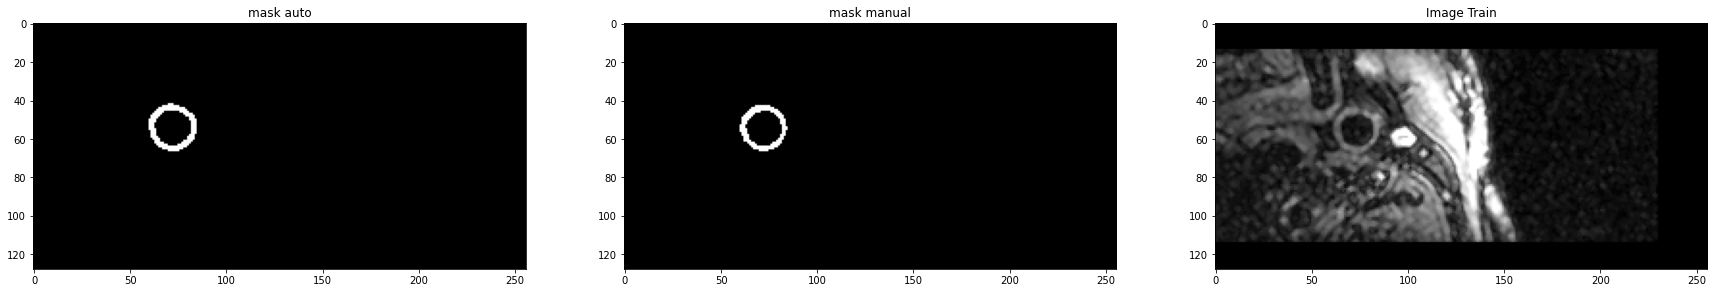

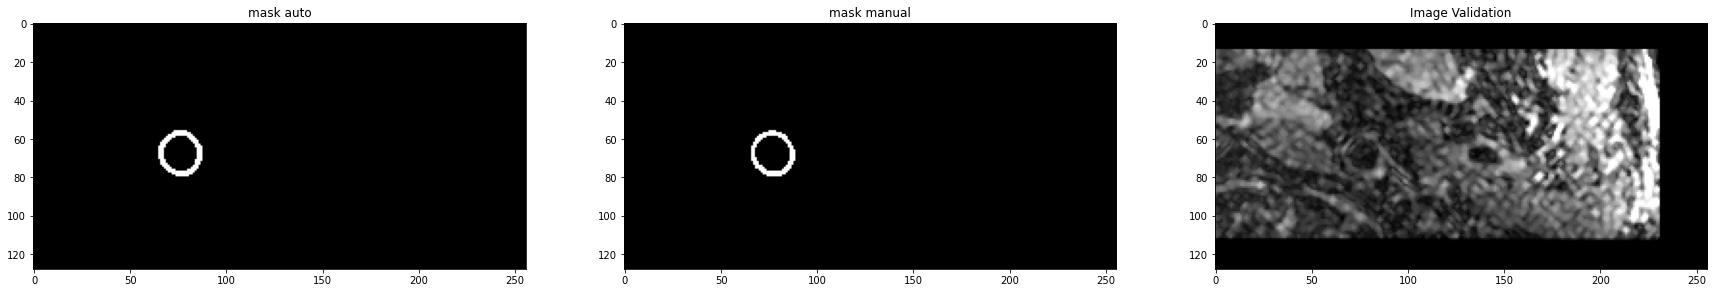

In [ ]:
label = {0:'Background', 1:'Lume', 2:'Wall'}

set_label = 2

random_index_train = random.randint(0, len(Y_train))
# random_index_train = 265

fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(131)
ax1.imshow(Mask_auto_train[random_index_train][:,:,set_label], cmap='gray'), ax1.set_title('mask auto')
ax2 = fig.add_subplot(132)
ax2.imshow(Y_train[random_index_train][:,:,set_label], cmap='gray'), ax2.set_title('mask manual')
ax3 = fig.add_subplot(133)
ax3.imshow(X_train[random_index_train], cmap='gray'), ax3.set_title('Image Train')

random_index = random.randint(0, len(Y_val))
# random_index = 21

fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(131)
ax1.imshow(Mask_auto_val[random_index][:,:,set_label], cmap='gray'), ax1.set_title('mask auto')
ax2 = fig.add_subplot(132)
ax2.imshow(Y_val[random_index][:,:,set_label], cmap='gray'), ax2.set_title('mask manual')
ax3 = fig.add_subplot(133)
ax3.imshow(X_val[random_index], cmap='gray'), ax3.set_title('Image Validation')

print("Random slice Training:", random_index_train)
print("Random slice Validation:", random_index)

# Ensemble:

In [ ]:
# model1 = load_model(path_mdl+'/'+'Unet_resnet34_3classes_Left_pesi3_best/model_Unet_resnet34_3classes_Leftshort_withPerc.hdf5', compile=False)
# model2 = load_model(path_mdl+'/'+'Unet_efficientnetb7_3classes_new_Left/model_Unet_efficientnetb7_3classes_new_Left_withall.hdf5', compile=False)
# model3 = load_model(path_mdl+'/'+'Unet_resnet50_3classes_new_Left/model_Unet_resnet50_3classes_new_Left_withPerc.hdf5', compile=False)

In [ ]:
# # Calcolo maschere automatiche per training
# z,x,y,c = Y_train.shape
# Mask_auto_train = np.zeros((z,x,y,c), dtype=np.uint8)
# weight_1 = 0.7
# weight_2 = 0.9
# weight_3 = 0.8
# threshold = 0.5

# cont_slice=0
# print('Training:')
# for slice_ in tqdm(X_train):
#     img = np.expand_dims(slice_, axis=0)

#     mask_auto1 = model1.predict(img)
#     mask_auto2 = model2.predict(img)
#     mask_auto3 = model3.predict(img)
#     mask_auto = (mask_auto1*weight_1+mask_auto2*weight_2+mask_auto3*weight_3)
#     mask_auto[mask_auto<threshold] = 0
#     mask_auto[mask_auto>=threshold] = 1

#     Mask_auto_train[cont_slice] = mask_auto
#     cont_slice += 1

# # Calcolo maschere automatiche per validation
# z,x,y,c = Y_val.shape
# Mask_auto_val = np.zeros((z,x,y,c), dtype=np.uint8)

# cont_slice=0
# print('Validation:')
# for slice_ in tqdm(X_val):
#   img = np.expand_dims(slice_, axis=0)

#   mask_auto1 = model1.predict(img)
#   mask_auto2 = model2.predict(img)
#   mask_auto3 = model3.predict(img)
#   mask_auto = (mask_auto1*weight_1+mask_auto2*weight_2+mask_auto3*weight_3)

#   mask_auto[mask_auto<threshold] = 0
#   mask_auto[mask_auto>=threshold] = 1

#   Mask_auto_val[cont_slice] = mask_auto
#   cont_slice += 1

Training:


100%|██████████| 1723/1723 [02:07<00:00, 13.53it/s]


Validation:


100%|██████████| 269/269 [00:19<00:00, 13.85it/s]


Random slice Training: 893
Random slice Validation: 192


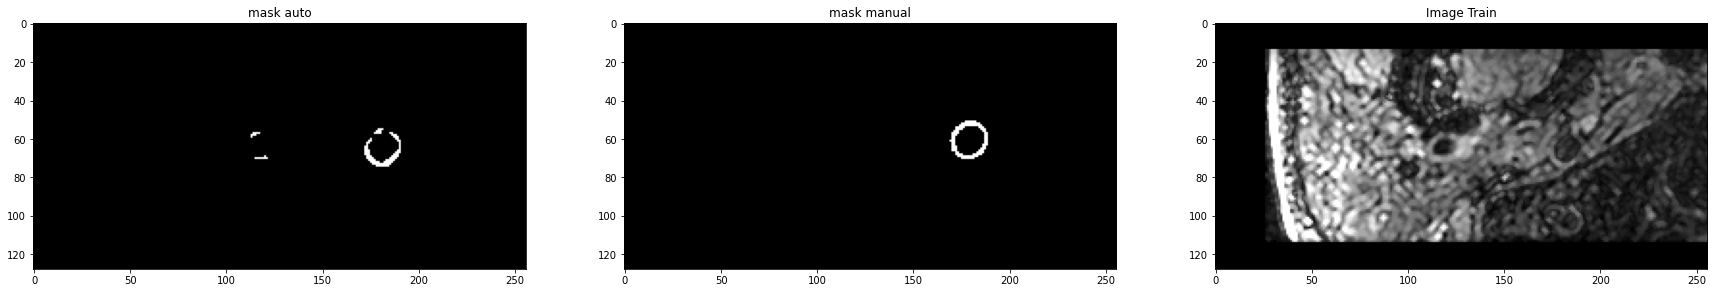

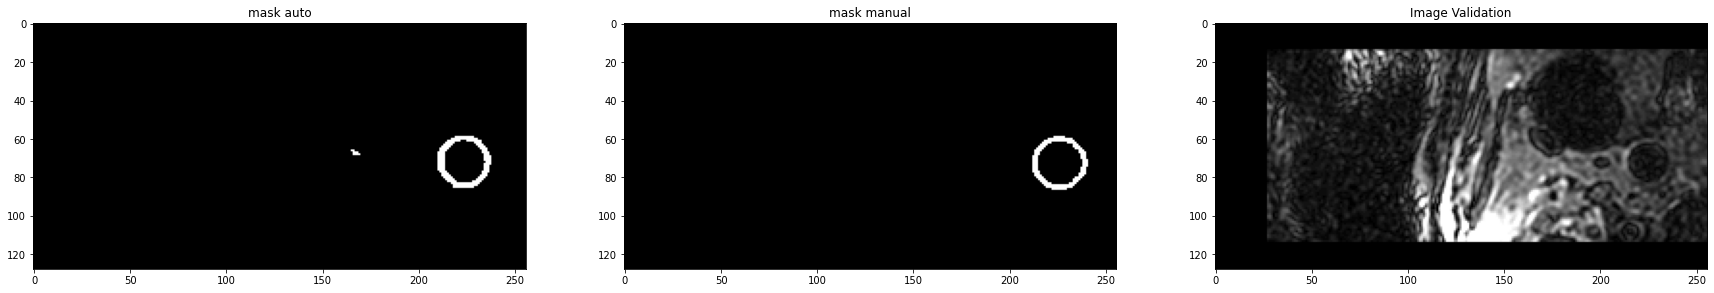

In [ ]:
# label = {0:'Background', 1:'Lume', 2:'Wall'}

# set_label = 2

# random_index_train = random.randint(0, len(Y_train))
# # random_index_train = 265

# fig = plt.figure(figsize=(30,30))
# ax1 = fig.add_subplot(131)
# ax1.imshow(Mask_auto_train[random_index_train][:,:,set_label], cmap='gray'), ax1.set_title('mask auto')
# ax2 = fig.add_subplot(132)
# ax2.imshow(Y_train[random_index_train][:,:,set_label], cmap='gray'), ax2.set_title('mask manual')
# ax3 = fig.add_subplot(133)
# ax3.imshow(X_train[random_index_train], cmap='gray'), ax3.set_title('Image Train')

# random_index = random.randint(0, len(Y_val))
# # random_index = 21

# fig = plt.figure(figsize=(30,30))
# ax1 = fig.add_subplot(131)
# ax1.imshow(Mask_auto_val[random_index][:,:,set_label], cmap='gray'), ax1.set_title('mask auto')
# ax2 = fig.add_subplot(132)
# ax2.imshow(Y_val[random_index][:,:,set_label], cmap='gray'), ax2.set_title('mask manual')
# ax3 = fig.add_subplot(133)
# ax3.imshow(X_val[random_index], cmap='gray'), ax3.set_title('Image Validation')

# print("Random slice Training:", random_index_train)
# print("Random slice Validation:", random_index)